#Financial News Sentiment Analysis


> About the Dataset

India financial news sentiment analysis dataset compiled together.

Date range: Jan 1, 2017 to April 15, 2021

News sources:
Indian sources: Economic Times, Money Control, Livemint, Business Today, Financial Express
Foreign sources: NY Times, WSJ, Washington Post

Keywords:
Indian sources: "economy" or "markets" or "inflation"
Foreign sources: "Indian economy" OR "India economy" OR "Indian businesses" OR "Indian business"

Sentiment analysis: Performed using flair NLP model. All confidence scores for NEGATIVE sentiment datapoints have been multiplied by -1 from the original flair output. Basic cleanup of data done to remove repetition of headlines and all headlines less than 30 characters are ignored.

Acknowledgements: GDELT Headline Scrape script from Prof. Ken Blake (https://drkblake.com/gdeltheadlinescrape/) has been used to generate the news headlines dataset.

Motivation: The intent of generating this data was to compile recent years financial news headlines for India and perform sentiment analysis on it.



Connecting Google Colab to Kaggle to get Dataset directly to colab

In [ ]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle_datasets/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download harshrkh/india-financial-news-headlines-sentiments

 65% 10.0M/15.4M [00:00<00:00, 43.7MB/s]
100% 15.4M/15.4M [00:00<00:00, 58.9MB/s]


Downloading the helper functions designed by mrdbourke which contains custom functions

In [ ]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-10-28 11:53:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-28 11:53:23 (85.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



Importing required functions from helper functions

In [ ]:
from helper_functions import unzip_data, plot_loss_curves, make_confusion_matrix

unziping the dataset

In [ ]:
unzip_data("india-financial-news-headlines-sentiments.zip")

Importing required libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

#Part 1 : Data Preprocessing

importing the dataset 

In [ ]:
df = pd.read_csv("News_sentiment_Jan2017_to_Apr2021.csv")

In [ ]:
df.head()

,Date,Title,URL,sentiment,confidence,Unnamed: 5
0,05/01/17,Eliminating shadow economy to have positive im...,http://economictimes.indiatimes.com/news/econo...,POSITIVE,0.996185,NaN
1,05/01/17,Two Chinese companies hit roadblock with India...,http://economictimes.indiatimes.com/news/econo...,NEGATIVE,-0.955493,NaN
2,05/01/17,SoftBank India Vision gets new $100,http://economictimes.indiatimes.com/small-biz/...,POSITIVE,0.595612,NaN
3,05/01/17,Nissan halts joint development of luxury cars ...,http://economictimes.indiatimes.com/news/inter...,NEGATIVE,-0.996672,NaN
4,05/01/17,Despite challenges Rajasthan continues to prog...,http://economictimes.indiatimes.com/news/polit...,POSITIVE,0.997388,NaN


Label Encoding to sentiment column


> Details

As we are dealing with binary classification, we need to convert sentiment column class name ("POSITIVE", "NEGATIVE") to binary(0,1) because we are going to process this data to Neural Network , the class value must be in binary for this problem



In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

In [ ]:
df.head()

,Date,Title,URL,sentiment,confidence,Unnamed: 5
0,05/01/17,Eliminating shadow economy to have positive im...,http://economictimes.indiatimes.com/news/econo...,1,0.996185,NaN
1,05/01/17,Two Chinese companies hit roadblock with India...,http://economictimes.indiatimes.com/news/econo...,0,-0.955493,NaN
2,05/01/17,SoftBank India Vision gets new $100,http://economictimes.indiatimes.com/small-biz/...,1,0.595612,NaN
3,05/01/17,Nissan halts joint development of luxury cars ...,http://economictimes.indiatimes.com/news/inter...,0,-0.996672,NaN
4,05/01/17,Despite challenges Rajasthan continues to prog...,http://economictimes.indiatimes.com/news/polit...,1,0.997388,NaN


Spliting the data into train_sentences, val_sentences, train_labels, val_labels

In [ ]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(df['Title'].to_numpy(),
                                                                            df['sentiment'].to_numpy(),
                                                                            test_size = 0.2,
                                                                            random_state = 42)

Create datasets (as fast as possible)



> tf.data: Build TensorFlow input pipelines and better performance with the tf.data API
  

we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.



In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels))



In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Part 2 : Embeding the Inputs (sentences) using Transfer Learning



> Converting text into numbers

you can build your own tokenizer and embedding layer but for this problem im gonna using  pre-trained word embeddings i.e Universal Sentence Encoder




loading pretrained model from hub to colab

In [ ]:
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder-large/5')

creating sentence encoder layer which we gonna add in neural network

In [ ]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5", input_shape = [], dtype = "string")

#Part 3 : Build the Deep Learning Model 

Building LSTM Model using Functional Api

In [ ]:
inputs = layers.Input(shape = [], dtype = "string", name = "input_layer")
x = sentence_encoder_layer(inputs)
x = tf.expand_dims(x, axis = 1)
x = layers.Bidirectional(layers.LSTM(72, return_sequences = True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(72, return_sequences = True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(72))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid', name = 'output_layer')(x)
model = tf.keras.Model(inputs, outputs, name = "model_lstm")

model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ['accuracy'])




Fitting the Model

In [ ]:
history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 10)

Epoch 1/10
5013/5013 [==============================] - 339s 61ms/step - loss: 0.4942 - accuracy: 0.7598 - val_loss: 0.4693 - val_accuracy: 0.7744
Epoch 2/10
5013/5013 [==============================] - 304s 61ms/step - loss: 0.4718 - accuracy: 0.7736 - val_loss: 0.4597 - val_accuracy: 0.7808
Epoch 3/10
5013/5013 [==============================] - 288s 57ms/step - loss: 0.4625 - accuracy: 0.7799 - val_loss: 0.4519 - val_accuracy: 0.7845
Epoch 4/10
5013/5013 [==============================] - 285s 57ms/step - loss: 0.4543 - accuracy: 0.7844 - val_loss: 0.4476 - val_accuracy: 0.7879
Epoch 5/10
5013/5013 [==============================] - 293s 58ms/step - loss: 0.4465 - accuracy: 0.7889 - val_loss: 0.4422 - val_accuracy: 0.7915
Epoch 6/10
5013/5013 [==============================] - 304s 61ms/step - loss: 0.4406 - accuracy: 0.7927 - val_loss: 0.4401 - val_accuracy: 0.7922
Epoch 7/10
5013/5013 [==============================] - 283s 57ms/step - loss: 0.4350 - accuracy: 0.7957 - val_loss: 0

ploting the loss and accuracy curves

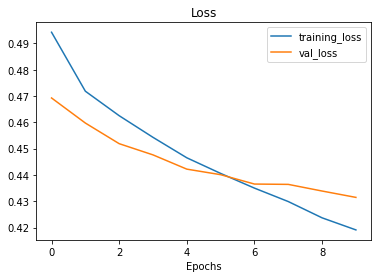

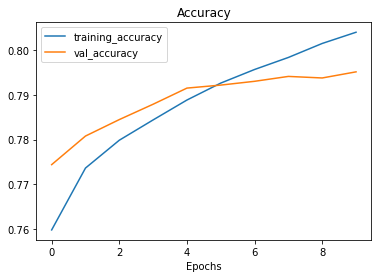

In [ ]:
plot_loss_curves(history)

#Part 4 : Evaluating the Trained Model

Testing Model on Validation sentences

In [ ]:
y_probs = model.predict(val_sentences)


1254/1254 [==============================] - 57s 40ms/step


converting the probabilities  in y_probs variables to class

In [ ]:
y_preds = tf.round(y_probs)

Comparing the results with actual validation labels with model predicted labels

In [ ]:
y_preds[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)>

In [ ]:
val_labels[:10]

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0])

Building the Confustion Matrix to check model performance

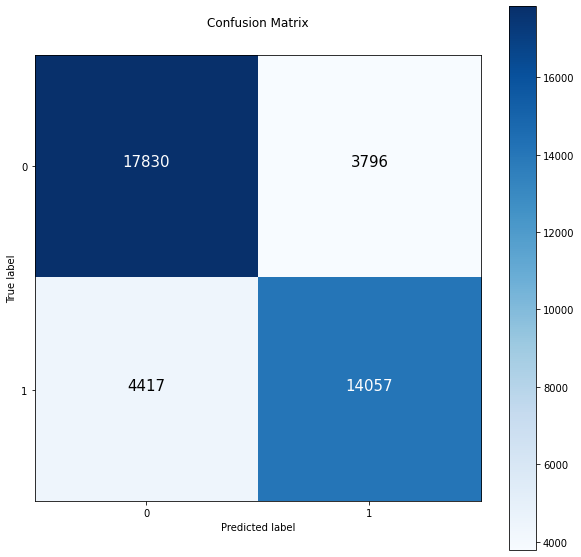

In [ ]:
make_confusion_matrix(val_labels, y_preds)

Saving the model for Deployment

In [ ]:
model.save('best_model.h5')

loading the model to ceck whether all weights are saved

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/kaggle_datasets/Financial news sentiment analysis/best_model.h5",custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
model.evaluate(valid_dataset)

#Part 5 : Realtime Testing of the Trained Model before Deployment

sentence from Economics Times

In [ ]:
custom = "Student loan forgiveness has scammers ‘on the move,’ warns FTC"

creating a function to predict whether its is postive or negative news

In [ ]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(It's a Positive News)" if pred_label > 0 else "(It's a Negative News)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

Results

In [ ]:
predict_on_sentence(model = model, sentence=custom)

1/1 [==============================] - 6s 6s/step
Pred: 0.0 (It's a Negative News) Prob: 0.03540654480457306
Text:
Student loan forgiveness has scammers ‘on the move,’ warns FTC
